In [1]:
#目的：想知道男和女分別去急診就診原因及所佔的比例
#Step 1:read file -->dataframe

from typing import Union, Tuple, Optional
#Optional[X] is equivalent to X | None (or Union[X, None]).   none是一種type，如果你打的不是x，就是None
#Union[X, Y] is equivalent to X | Y and means either X or Y.   


import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from matplotlib.axes import Axes

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #用來正常顯示中文標籤
plt.rcParams['axes.unicode_minus'] = False   #用來正常顯示負號


def load_csv(p: Union[Path, str]) -> pd.DataFrame:   #p：不是path 就是str字串的type，然後->pd.df代表函式回傳會是df type
    """                                              
    load csv file

    :param p: csv path or containing folder
    :return:
        pd.DataFrame
    """
    if isinstance(p, str):         # isinstance(object, classinfo)是一個内置函數，判断p(object)是否是已知的類型str(classinfo)
        p = Path(p)                #p是path type

    if 'csv' in p.name:
        return pd.read_csv(p, encoding='utf-8')

    else:
        f = list(p.glob('*.csv'))   #    如果沒有csv檔的文件，就用.glob去找檔案.  *:匹配所有的內容,要讀什麼檔案類型：.txt, .csv
        if len(f) == 0:                                             #如果都沒有 就顯示no cvs file...
            raise FileNotFoundError(f'no csv file under the {p}')  
        elif len(f) == 1:                                          #如果有1個，就去讀f的第一個出現csv檔
            return pd.read_csv(f[0], encoding='utf-8')
        else:
            raise RuntimeError(f'multiple csv files under the {p}')  #如果太多csv檔案，就顯示multiple cvs files...
            
#a=load_csv("/Users/wei/er-visit-statistics/test_file/Summary_of_patients_in_ER_20210318.csv")
#a

In [2]:
#Step2: (1)部分資料先中改英 (2)分別抓出個年齡層 (3)分別抓出男生和女生 (4)人數row排序遞減 (5)取出男女分別總病人數,算就診率 

#(1)部分資料先中改英
def parse_csv(df: pd.DataFrame,  #parse_csv() 給指令來分類，分csv檔案裡的東西。
              gender: str,
              age_range: Optional[Tuple[int, int]] = None) -> pd.DataFrame:
    """
    translate, select ages and gender from raw dataframe

    :param df:
    :param gender: {'M', 'F'}
    :param age_range: whether specify the range of ages
    :return:
    """

    df.columns = ["Gender", "Age", "Diseases", "Patients"]
    df["Gender"].replace({"女": "F", "男": "M"}, inplace=True)
    df["Diseases"].replace({"呼吸系統疾病":"Respiratory Disease",
                        "消化系統疾病":"Digestive system disease",
                        "急性上呼吸道感染和流行性感冒":"Acute upper respiratory tract infection & Influenza",
                        "腹痛及骨盆痛":"Abdominal and Pelvic pain","生殖泌尿系統疾病":"Genitourinary disease",
                        "循環系統疾病":"Circulatory system disease","其他頭部損傷":"Head injury",
                        "其他泌尿系統疾病":"Other urinary system disease",
                        "其他及未明示非傳染性胃腸炎及結腸炎":"Unknown noninfective enteritis and colitis",
                        "內分泌、營養和代謝疾病":"Endocrine, nutritional and metabolic disease",
                        "皮膚及皮下組織疾病":"Skin and subcutaneous tissue disease",
                        "感染症及寄生蟲病":"Infectious disease & Parasite infection"},inplace=True)
    

#(2)分別抓出個年齡層
# age mask
    if age_range is None:   #如果age沒顯示幾歲（沒範圍），就顯示總計
        m = df['Age'] == "總計"
    elif age_range[1]-age_range[0] != 4:
        print ("please do the age difference to equal four.")
    elif age_range[0] %5 !=0:      # 第一個數除以5不會有餘數，如果有餘數 就顯示 print裡的文字
        print ("please notice that the first age is a multiple of 5.")
    else:
        if age_range[0] != 85:     #如果輸入的年齡，[0]不等於85
            m = df['Age'] == f'{age_range[0]}~{age_range[1]}歲'   #就顯示幾歲到幾歲
        else:  # above 85 years-old
            m = df['Age'] == f'{age_range[0]}歲以上'
    df = df[m]



#(3)分別抓出男生和女生 
# gender mask
    gm = df['Gender'] == gender
#(4)人數row排序遞減
    df = df[gm].sort_values(['Patients'], ascending=False)
#(5)取出男女分別總病人數.max()＋就診率
    total_pt = df['Patients'].max()
    df["Consultation rate(%)"] = df["Patients"] / total_pt * 100
    
    return df


In [3]:
#parse_csv(a,"M",[10,14])

In [4]:
#step3:畫圖

def _plot_bar(ax: Axes, df: pd.DataFrame, gender: str):   #Axes.bar()函數用於製作條形圖
    """bar plot"""
    x = df['Diseases'].to_numpy()   #將df 轉為array
    y = df['Consultation rate(%)'].to_numpy()

    for i in range(df.shape[0]):
        ax.bar(x[i], y[i], label=x[i])

    ax.get_xaxis().set_visible(False)   
    #Axes.get_xaxis(): Return the XAxis instance.
    #get_xaxis().set_visible(False)  不顯示X軸
    ax.set_ylabel('Consultation rate(%)')   #設y軸
    ax.set_title(f'Statistics of {gender} patients in ER') #設title
    ax.legend() #ax.legend()來顯示數據的名稱，名稱定義在label中
    plt.show()


#step4: 內容都打好了，最終要的就是：輸入路徑->寫"M" or "F"->寫年齡 ->排名前十名 .

def plot_er_stat(p: Union[Path, str],    #path 傳進去應是path 和str字串的type
                 gender: str,  
                 age_range: Optional[Tuple[int, int]] = None,
                 rank: int = 10):  #取前十名
    """

    :param p: csv path or containing folder
    :param gender: {'M', 'F'}
    :param age_range: whether specify the range of ages
    :param rank: top rank sorted by `Patients` numbers
    :return:
    """

    df = load_csv(p)
    df = parse_csv(df, gender, age_range)
    df = df[5:rank + 5]  # remove sum及remove 前四名無法分類的

    _, ax = plt.subplots()
    _plot_bar(ax, df, gender)




In [5]:
"""from pathlib import Path  #Path是一種type

p = Path.cwd()
print(p, type(p))"""

'from pathlib import Path  #Path是一種type\n\np = Path.cwd()\nprint(p, type(p))'

In [6]:
#練習寫function
#function  input : 路徑pathway (讀檔用)
# parameter : bool 分男女
#out put 是dataframe
#function 2 : input dataframe 做排序  output成一個dictionary
#讀plot.


"""keyword  argument:
在function input裡定義你要的parameter
ex:
def add(x,y)
add(x=4,y=5)

positoin argument:
keyword argumet 就是在function input按照位置放進去

ex:
def add (x,y)
add(4,5)"""


'keyword  argument:\n在function input裡定義你要的parameter\nex:\ndef add(x,y)\nadd(x=4,y=5)\n\npositoin argument:\nkeyword argumet 就是在function input按照位置放進去\n\nex:\ndef add (x,y)\nadd(4,5)'

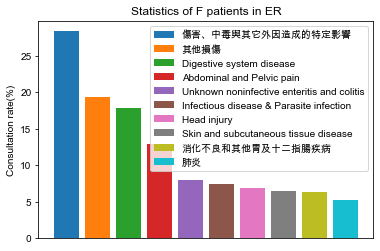

In [7]:
plot_er_stat("/Users/wei/visit_statistics/test_file/Summary_of_patients_in_ER_20210318.csv","F",[10,14])